# Introduction to Image Classification w/ Deep Learning

This notebook contains a tutorial on building Deep Learning algorithms to perform the classic computer vision task of image classification. It will take you through the life-cycle of machine learning development, from data exploration and preprocessing, to building and training our models, and finally to deploying models to the cloud and to AWS DeepLens, a fully programmable video camera that brings inference to the edge.

You will learn the following concepts:
* **Loading the Data**: Understand what image data looks like, as well as how to load and prepare image data for training a neural network.
* **Deep Learning Frameworks**: How to build and train deep learning models in both the native Apache MXNet symbolic framework and the imperative Gluon interface, understanding the difference between the two.
* **Training & Deployment on Amazon SageMaker**: How to convert existing model code to training scripts in order to launch training jobs through the SageMaker platform, as well as how to deploy trained models to an inference endpoint.
* **Edge Deployment on AWS DeepLens**: How to optimize and deploy models from SageMaker to AWS DeepLens for edge inference with Lambda functions.

## Background

Neural networks have quickly risen to prominence in many traditional machine learning domains, but none more so than computer vision. Convolutional Neural Networks (CNN's) in particular have now exceeded human performance at the task of image classification, a traditional starting point for any practitioner of computer vision. The task is as straightforward as it sounds: given a data set of **labelled** images, train a model that can predict the class of a new image.


## Loading the Data

Before we get into how we're going to build these models, let's take a look at what this data looks like.

### Imports

In [1]:
import numpy as np
import pandas as pd
import urllib3
import cv2
import mxnet as mx
from mxnet import ndarray as nd, autograd, gluon
from mxnet.gluon import nn
import urllib
from PIL import Image
from sklearn.cross_validation import train_test_split
import zipfile
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/src/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The data set we are going to use is the [GTSRB](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Imageformat) data set of German Traffic Signs. Before we can take a look, we'll first have to download what we need (this may take awhile), then extract.

In [7]:
urllib.urlretrieve('http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip', 'training_data.zip')
with zipfile.ZipFile('training_data.zip') as zipref:
    zipref.extractall('.')

('data.zip', <httplib.HTTPMessage instance at 0x7ff95ee83a70>)

Let's look at the data.

In [2]:
image_dir = 'GTSRB/Final_Training/Images'
image_files = glob.glob(os.path.join(image_dir, '*/*.ppm'))
image_files.sort()

We'll use the PIL library to open these images:

In [3]:
Image.open(image_files[0])

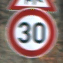

In [4]:
Image.open(image_files[1000])

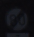

In [5]:
Image.open(image_files[10000])

We can see they're pretty small color images of signs of varying size. We can quickly convert them to arrays using <tt>numpy</tt>:

In [6]:
tmp = np.array(Image.open(image_files[0]))

Images are represented as three-dimensional arrays of 8-bit unsigned integers. The dimensions here are (height, width, channel), where channel corresponds to the three color channels Red, Green, and Blue (RGB) and the values indicate that channel's intensity.

In [7]:
tmp.shape

(46, 52, 3)

In [8]:
tmp

array([[[54, 47, 42],
        [60, 53, 47],
        [53, 45, 39],
        ..., 
        [42, 34, 30],
        [49, 41, 36],
        [43, 36, 30]],

       [[48, 41, 36],
        [51, 44, 38],
        [51, 44, 39],
        ..., 
        [46, 37, 35],
        [50, 41, 38],
        [46, 39, 34]],

       [[48, 40, 36],
        [46, 39, 35],
        [47, 41, 37],
        ..., 
        [50, 40, 38],
        [53, 43, 40],
        [44, 36, 32]],

       ..., 
       [[39, 37, 34],
        [35, 33, 29],
        [32, 30, 27],
        ..., 
        [42, 34, 33],
        [43, 36, 33],
        [42, 34, 29]],

       [[38, 37, 34],
        [34, 33, 29],
        [32, 31, 28],
        ..., 
        [41, 33, 31],
        [43, 37, 34],
        [44, 36, 32]],

       [[38, 37, 34],
        [36, 35, 31],
        [34, 33, 30],
        ..., 
        [48, 39, 36],
        [46, 39, 36],
        [43, 35, 31]]], dtype=uint8)

We're going to need to load the entire dataset into memory to begin training, but before we do that let's familiarize ourselves with the labelling convention. We need to match our input arrays with the correct label in order to train our model.

In [6]:
image_files[0:3]

['GTSRB/Final_Training/Images/00000/00000_00000.ppm',
 'GTSRB/Final_Training/Images/00000/00000_00001.ppm',
 'GTSRB/Final_Training/Images/00000/00000_00002.ppm']

In [7]:
image_files[-3:]

['GTSRB/Final_Training/Images/00042/00007_00027.ppm',
 'GTSRB/Final_Training/Images/00042/00007_00028.ppm',
 'GTSRB/Final_Training/Images/00042/00007_00029.ppm']

The directory under <tt>Images</tt> indicates the class that all the images in that directory correspond to. The mapping from id to class is contained in <tt>signnames.csv</tt>, we're going to use the Pandas library to easily open it and generate a dictionary for mapping.

In [8]:
df = pd.read_csv('signnames.csv', names=['idx', 'labels'], skiprows=[0])
label_map = df.to_dict()['labels']
label_map

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

Now that we understand how our images our mapped to our labels, we're going to load the images into memory as arrays along with corresponding labels. We'll generate the label by just extracting that id from the file path. Because the outputs are categories, these unique integer id's are the exact representation we need to train our model with.

Recall that the images are all of different size. This will present a problem in training our model, which requires that all inputs be the exact same dimension (if you're familiar w/ matrix algebra, you'll understand why). As such, we're going to resize all the arrays to a standard resolution of 32x32.

In [9]:
extract_label = lambda x: int(x.split('/')[-2])

X = []
Y = []
for image_file in image_files:
    X.append(np.array(Image.open(image_file).resize((32,32))))
    Y.append(extract_label(image_file))
X = np.stack(X)
Y = np.array(Y)

Our resulting arrays are 39209 image arrays w/ corresponding labels.

In [10]:
print(X.shape)
print(Y.shape)

(39209, 32, 32, 3)
(39209,)


Let's double check and make sure they align:

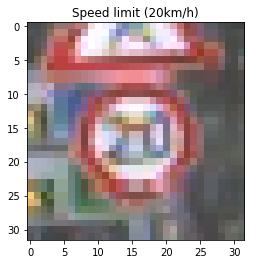

In [11]:
idx = 0
plt.figure()
plt.title(label_map[Y[idx]])
plt.imshow(X[idx])

It's difficult to make out but we can see it is indeed a 20 km/h speed limit sign.

Now that we have loaded and processed our data into a uniform resolution, we're ready to move on to building our network. There are two additional steps to take in preprocessing the input which we'll discuss ahead.

## Deep Learning Frameworks

If you are familiar with classic machine learning algorithms, you are probably have seen the previous steps. However, it is at this point where the development diverges from ML. 

Deep learning models are significantly more complex and resource-intensive. They utilize high-dimensional matrix operations that are best computed on a GPU, which is highly optimized to do such computations at a massive scale. Due to the complexity of GPU computation, many deep learning frameworks and libraries have sprung up that manage the GPU programming in order to provide the practitioner with a high-level abstraction for training neural networks. 

However, the difference between classic machine learning algorithms and deep learning is not limited to just computational needs. The term "deep learning" refers to an entire family of models known as **neural networks**. In contrast to machine learning libraries like sci-kit learn, deep learning libraries are **not** a collection of pre-built algorithms, but are instead a collection of building blocks with which one can construct any network (hence the oft-used phrase neural network **architecture**"). We call these building blocks **layers**.

In this tutorial we will use the [Apache MXNet](https://mxnet.apache.org/) library to build a CNN, both in its native symbolic form and with the recently released [Gluon imperative interface](https://mxnet.incubator.apache.org/gluon/index.html).

### Apache MXNet

Apache MXNet (MXNet) is an open source deep learning framework designed to train neural networks at scale and efficiently.

But what is a neural network exactly?

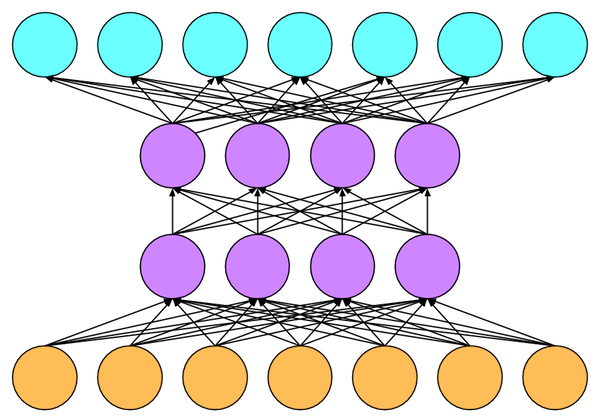

In [15]:
Image.open('mlp.png')

At the simplest level, they are chains of linear transformations and nonlinearities that learn to progessively output intermediate features useful to solving a certain task. If you aren't familiar with them in concept, I recommend you refer to [The Straight Dope](http://gluon.mxnet.io/) for a comprehensive introduction to deep learning architectures.

For this tutorial, we will be using a **convolutional** neural network, so named because they use convolutional layers to extract features patch-wise across spatial dimensions. These architectures have been found to be incredibly successful in a variety of C.V. problems, and you will train several in this notebook.

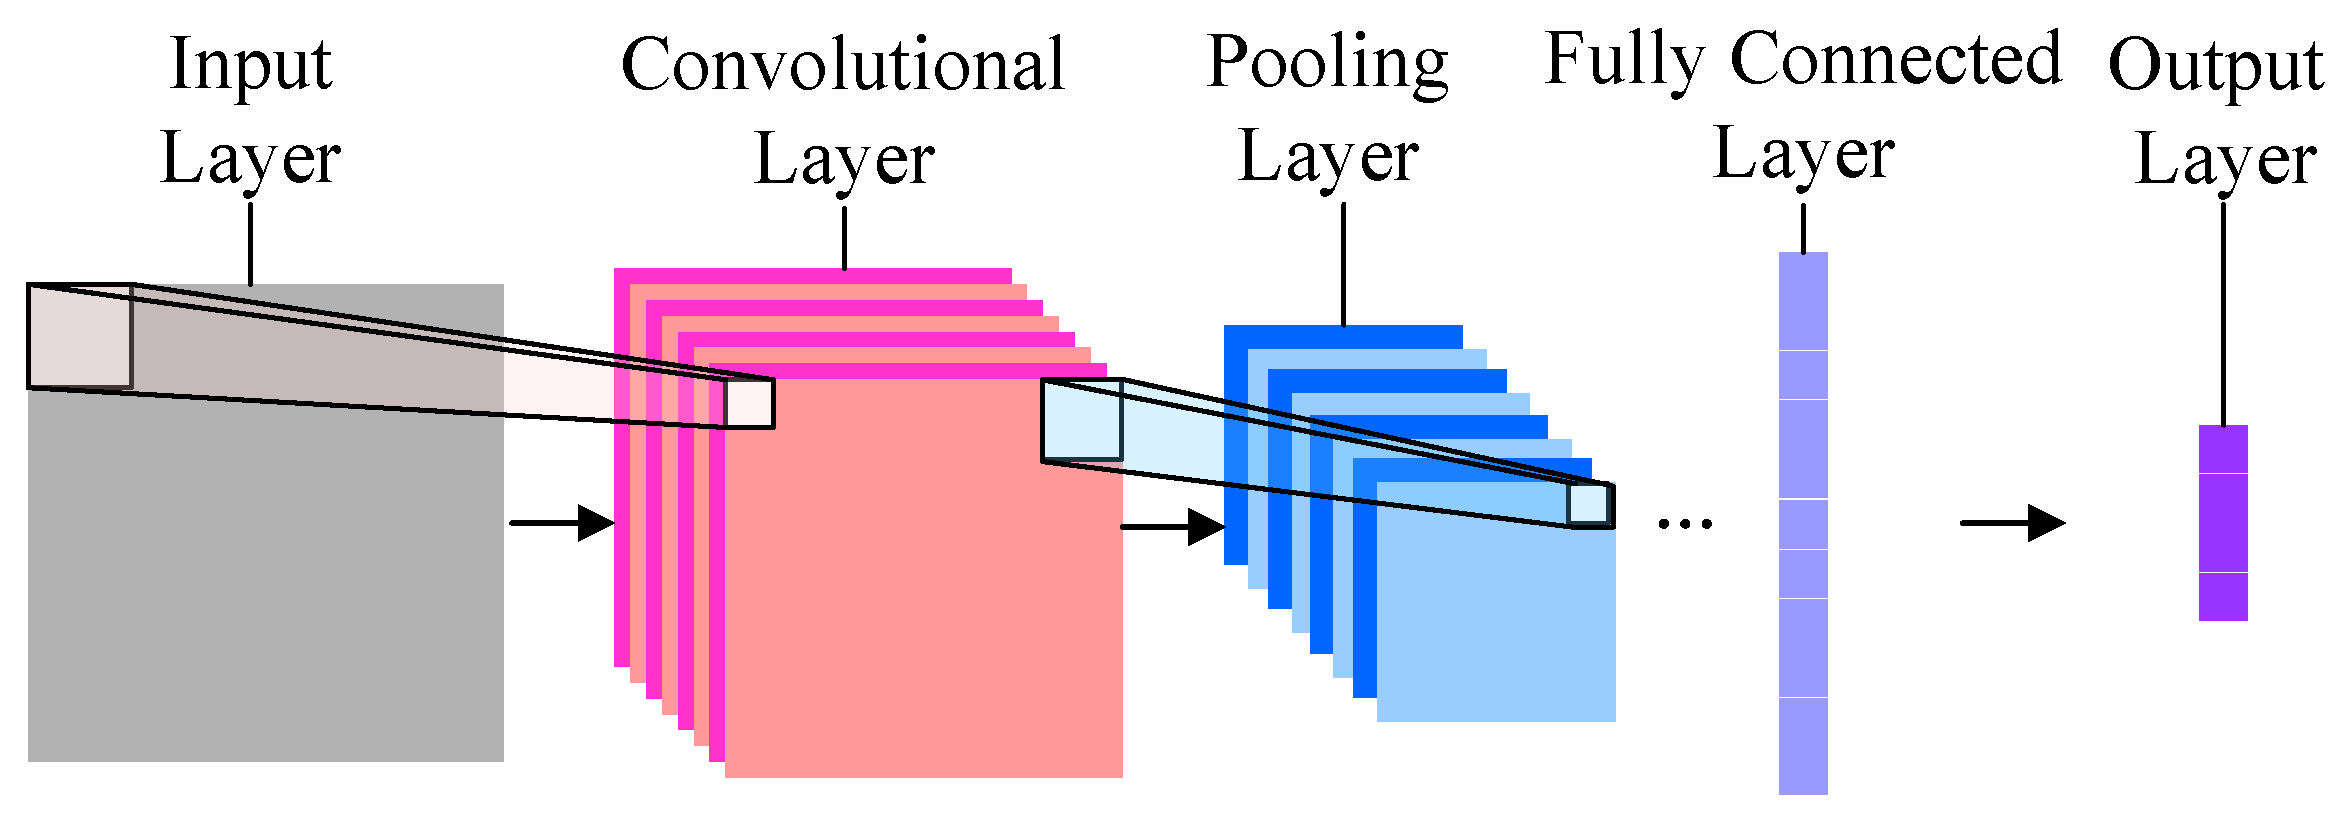

In [16]:
Image.open('cnn.png')

The model we'll build is a common first architecture known as LeNet. It has two convolutional layers to extract local, contextual features spatially, and two dense layers on top that help make global decisions necessary for classification. The output is a vector whose length is the number of categories; a prediction is made by the index of the highest value in the output (think of it as a probability vector). 

The build these networks, many frameworks including MXNet use **Symbolic** notation, meaning that the network **graph** is defined prior to running computation on it. In MXNet, each Symbol (<tt>mx.sym.</tt>) is a specific operation, and by chaining together operations we will define an entire network. By defining the graph ahead of time, the MXNet engine can make computational optimizations when training the model and running inference. 

(For a deeper dive on MXNet than is present in this notebook, please see the **Introduction to MXNet** notebook within this repository).

In [17]:
def conv_layer(x, nf, k):
    #convolution and activation
    x = mx.sym.Convolution(x, num_filter=nf, kernel=k)
    x = mx.sym.Activation(x, act_type='relu')
    #max pooling reduces spatial dimension by half, increasing receptive field
    x = mx.sym.Pooling(x, kernel=(2,2), stride=(2,2), pool_type='max')
    return x

def build_cnn(conv_params, num_hidden, num_classes):

    #Input and label placeholders
    data = mx.sym.Variable('data')
    label = mx.sym.Variable('softmax_label')

    #build conv layers
    x = data
    for i, conv_param in enumerate(conv_params):
        x = conv_layer(x, conv_param[0], conv_param[1])

    #flatten to fully dense layer
    x = mx.sym.Flatten(x, name='flat_1')
    #hidden layer
    x = mx.sym.FullyConnected(x, num_hidden=num_hidden, name='fc_1')
    x = mx.sym.Activation(x, act_type='relu', name='relu_3')
    #dense to vector of class length
    output = mx.sym.FullyConnected(x, num_hidden=num_classes, name='fc_2')
    #categorical cross-entropy 
    loss = mx.sym.SoftmaxOutput(output, label, name='softmax')
    return loss

The final symbol, <tt>SoftmaxOutput</tt>, computes the output vector and then computes the categorical cross-entropy with the true label. This function is the **loss** function, something that measures how "off" the predictions are from the ground truth. A network is trained by updating the weights to minimize this loss function through **backpropagation**.

In [18]:
sym = build_cnn([[20, (5,5)], [50, (5,5)]], 128, len(label_map.keys()))

Now that we've built the computational graph symbolically, we can visualize it:

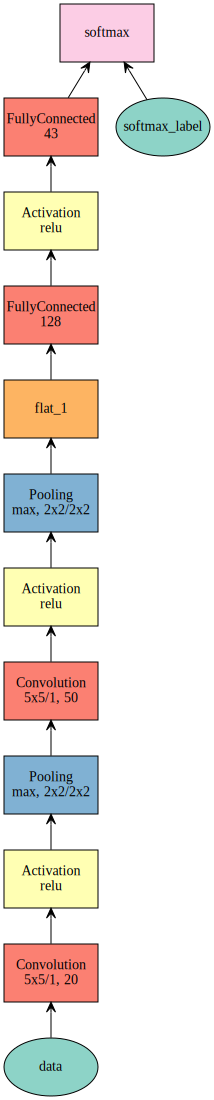

In [20]:
mx.viz.plot_network(sym)

Having defined the model symbolically, the next step is to finish preparing our data for training, and then bind the model. MXNet expects input dimensions as <tt>(batch_size, channel, height, width)</tt>, so we need to rearrange some axes.

In [21]:
X = np.transpose(X, axes=(0, 3, 1, 2))

In [22]:
X.shape

(39209, 3, 32, 32)

Next we split the data into a training and validation set, which we hold out to test metrics on to ensure our model doesn't overfit.

In [23]:
train_X, validation_X, train_Y, validation_Y = train_test_split(X, Y, test_size=0.2, random_state=1984)

Finally, we load the dataset into an MXNet NDArray iterator. This will yield shuffled data at a specific batch size for the network to train on. Due to computational constraints, neural networks don't train on an entire dataset at once. However, the stochasticity from training on batches turns out to be advantageous to minimizing the loss function.

In [24]:
batch_size = 64
train_iter = mx.io.NDArrayIter(data=train_X, label=train_Y, batch_size=batch_size, shuffle=True)
validation_iter = mx.io.NDArrayIter(data=validation_X, label=validation_Y, batch_size=batch_size)

Now that we've built iterators, we can take the network symbol we created and build a module to execute for training. We'll also define the context (CPU, GPU) where the network weights will live on. This can be multi-gpu as well.

**Note:** If you are not on a GPU-enabled machine or haven't installed MXNet for GPU computing, then you can't use a GPU context! You can probably train this model on CPU if need be.

In [25]:
ctx = mx.gpu(0)
# ctx = mx.cpu()
net = mx.mod.Module(sym, context=ctx)

Finally, we can start training the model. Calling fit on our network does the following:
* Bind the network graph to the data shapes. This informs the model how to allocate memory
* Initialize weights
* Initialize Adam optimizer. This is the algorithm that updates our weights to minimize the loss function. Adam is a step above the traditional SGD (Stochastic Gradient Descent) algorithm, and is frequently used. The learning rate helps inform the step size of parameter updates.
* Launch training loop for number of epochs, recording metrics as the model trains. MXNet uses logging to display training information

In [26]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
net.fit(train_iter,
        eval_data=validation_iter,
        initializer = mx.initializer.Xavier(magnitude=2.24),
        optimizer='adam',
        optimizer_params={'learning_rate':1E-3},
        eval_metric='acc',
        num_epoch=10)

INFO:root:Epoch[0] Train-accuracy=0.728010
INFO:root:Epoch[0] Time cost=2.090
INFO:root:Epoch[0] Validation-accuracy=0.918953
INFO:root:Epoch[1] Train-accuracy=0.938709
INFO:root:Epoch[1] Time cost=1.916
INFO:root:Epoch[1] Validation-accuracy=0.947790
INFO:root:Epoch[2] Train-accuracy=0.962608
INFO:root:Epoch[2] Time cost=1.920
INFO:root:Epoch[2] Validation-accuracy=0.944868
INFO:root:Epoch[3] Train-accuracy=0.966936
INFO:root:Epoch[3] Time cost=1.915
INFO:root:Epoch[3] Validation-accuracy=0.961763
INFO:root:Epoch[4] Train-accuracy=0.971264
INFO:root:Epoch[4] Time cost=1.916
INFO:root:Epoch[4] Validation-accuracy=0.938262
INFO:root:Epoch[5] Train-accuracy=0.972282
INFO:root:Epoch[5] Time cost=1.917
INFO:root:Epoch[5] Validation-accuracy=0.959477
INFO:root:Epoch[6] Train-accuracy=0.975401
INFO:root:Epoch[6] Time cost=1.916
INFO:root:Epoch[6] Validation-accuracy=0.959985
INFO:root:Epoch[7] Train-accuracy=0.974955
INFO:root:Epoch[7] Time cost=1.916
INFO:root:Epoch[7] Validation-accuracy=0

Set logging level back to warning.

In [44]:
logging.getLogger().setLevel(logging.WARNING)

In only ten epochs, we've achieved a classification accuracy of 98.8%! 

Let's try this network out on data from images we can find online to see if the model generalizes. The following function will pull an image from a url and preprocess it for prediction.

In [28]:
import urllib3

http = urllib3.PoolManager()

def get_image(url):
    req = http.request('GET', url)
    arr = np.asarray(bytearray(req.data), dtype=np.uint8)
    cv2_img = cv2.imdecode(arr, -1)
    og_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    
    # (batch_size, channels, height, width)
    img = cv2.resize(og_img, (32, 32))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img, og_img

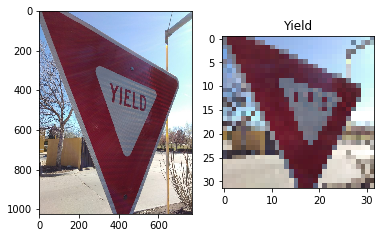

In [45]:
url = "http://www.photos-public-domain.com/wp-content/uploads/2017/04/yield-sign-768x1024.jpg"
img, og_img = get_image(url)
test_iter = mx.io.NDArrayIter(data=np.concatenate(128*[img]), label=np.zeros((128,)))
batch = next(test_iter)
net.forward(batch, is_train=False)
outputs = net.get_outputs()[0]

predicted_label = label_map[np.argmax(outputs.asnumpy())]
un_normalized_img = np.transpose(img[0], axes=(1,2,0))

plt.figure()
plt.subplot(121)
plt.imshow(og_img)
plt.subplot(122)
plt.title(predicted_label)
plt.imshow(un_normalized_img)

Great! Even at really low resolution, the model is able to recognize the Yield sign that it has never seen before. As indicated by the high validation metric during training, this model is able to generalize well to data it has never seen. 

### Gluon

Now that we've seen how to train a neural network by defining a symbolic graph first, we'll proceed to do this **imperatively** through Gluon. 

Gluon is a high-level, easy to use interface that sits on top of MXNet. The main difference in functionality is that model building, and more importantly training, can be done imperatively. This makes a difference when your model is not simple, is composed of multiple models, or has a lot of moving pieces that isn't possible to define as a symbolic graph. 

This is accomplished with Gluon's <tt>autograd</tt> package, which can track any imperative NDArray computation within it's scope and propagate gradients backwards. 

Let's go ahead and rebuild our model in Gluon using the <tt>HybridSequential</tt> constructor:
* The <tt>Sequential</tt> constructor allows you to add on layers to your model. Any feedforward passes will propagate through in the order they were attached (reverse for backprop)
* <tt>HybridSequential</tt> does the same, but it is "Hybrid" because you can choose to <tt>hybridize</tt> the model after you build it, which constructs a graph for forward computation that helps recover some lost efficiency of a full computation graph.

In [30]:
def build_cnn_gluon(conv_params, num_hidden, num_classes):

    cnn_layers = gluon.nn.HybridSequential(prefix='')
    for ch, k_sz in conv_params:
        cnn_layers.add(gluon.nn.Conv2D(channels=ch, kernel_size=k_sz, activation='relu'))
        cnn_layers.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=2)) # strides fixed for now

    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(cnn_layers)
        # Flatten and apply fully connected layers
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(num_hidden, activation="relu"))
        net.add(gluon.nn.Dense(num_classes))

    # speed up execution with hybridization
    net.hybridize()
    return net

In [31]:
net_gluon = build_cnn_gluon([[20, (5,5)], [50, (5,5)]], 128, len(label_map.keys()))

Now that we've built and hybridized the model, we can initialize our model weights and training optimizer, as well as define our loss function and metrics.

In [32]:
def evaluate_accuracy(net, data_iterator):
    acc = mx.metric.Accuracy()
    while True:
        try:
            batch = next(data_iterator)
        except StopIteration:
            train_iter.reset()
            break        
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [33]:
net_gluon.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = mx.gluon.Trainer(net_gluon.collect_params(), 'adam', {'learning_rate': 1E-3})

The next part is very different from training in symbolic. Here, we're actually going to write our own training loop, and record the gradients of imperative computations on the fly.

For each epoch:
* Iterate through every batch available in training iterator.
* Switch data arrays to GPU context for network computation
* Autograd begins to record gradients immediately before we do a forward pass of the input through the network
* While gradients are still being tracked, the loss is calculated. 
* Finally, that loss NDArray uses the <tt>backward()</tt> method to initialize a backwards pass from that array through all prior computations since the beginning of gradient recording.
* Lastly the optimizer takes a step and updates parameters accordingly.

Notice that we had to manually switch the data NDArray to the same context as the network to run computation. This is done automatically when training in Symbolic, so while Gluon provides greater control it also gives you more responsibility in managing your data's memory.

In [34]:
smoothing_constant = .01
epochs = 10
ctx = ctx
loss_vals = []
train_acc = []
val_acc = []
train_iter.reset()
validation_iter.reset()

for e in range(epochs):
    i = 0
    while True:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        #print data.shape, label.shape
        with autograd.record(train_mode=True):
            output = net_gluon(data)
            loss = loss_function(output, label)
        loss.backward()
        optimizer.step(data.shape[0])

        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        loss_vals.append(moving_loss)
        i +=1
        
    train_accuracy = evaluate_accuracy(net_gluon, train_iter)
    train_iter.reset()
    test_accuracy = evaluate_accuracy(net_gluon, validation_iter)
    validation_iter.reset()
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
    train_acc.append(train_accuracy)
    val_acc.append(test_accuracy)

Epoch 0. Loss: 0.998038572355, Train_acc 0.899885437882, Test_acc 0.890370934959
Epoch 1. Loss: 0.259994242376, Train_acc 0.940109470468, Test_acc 0.926575203252
Epoch 2. Loss: 0.206321649024, Train_acc 0.955511710794, Test_acc 0.939659552846
Epoch 3. Loss: 0.146618912023, Train_acc 0.97524185336, Test_acc 0.957952235772
Epoch 4. Loss: 0.145393294407, Train_acc 0.971168533605, Test_acc 0.955538617886
Epoch 5. Loss: 0.13987805211, Train_acc 0.971041242363, Test_acc 0.949949186992
Epoch 6. Loss: 0.134212951484, Train_acc 0.970436608961, Test_acc 0.95299796748
Epoch 7. Loss: 0.11922292595, Train_acc 0.971073065173, Test_acc 0.954141260163
Epoch 8. Loss: 0.0974416939252, Train_acc 0.976355651731, Test_acc 0.958587398374
Epoch 9. Loss: 0.106147934245, Train_acc 0.982815682281, Test_acc 0.962144308943


We can see we get very much the same results here, but with the freedom of being able to imperatively use the model as opposed to the constraints of the symbolic model.

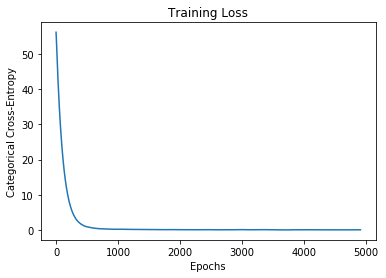

In [35]:
plt.figure()
plt.title('Training Loss')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epochs')
plt.plot(loss_vals)

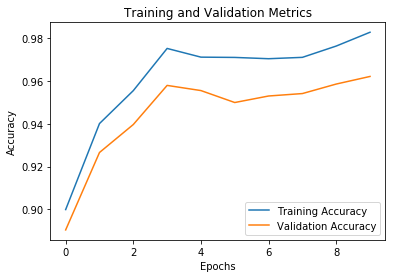

In [36]:
plt.figure()
plt.title('Training and Validation Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Training Accuracy', 'Validation Accuracy'])

We'll do the same validation on data in the wild as before, noting again that we explicitly have to manage the memory of the data by putting it in the correct context.

/home/ubuntu/src/anaconda2/lib/python2.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


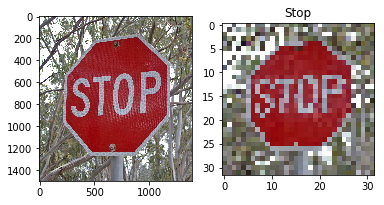

In [46]:
url = "https://upload.wikimedia.org/wikipedia/commons/f/f9/STOP_sign.jpg"
img, og_img = get_image(url)
outputs = net_gluon(nd.array(img).as_in_context(ctx))

predicted_label = label_map[np.argmax(outputs.asnumpy())]
un_normalized_img = np.transpose(img[0], axes=(1,2,0))

plt.figure()
plt.subplot(121)
plt.imshow(og_img)
plt.subplot(122)
plt.title(predicted_label)
plt.imshow(un_normalized_img)

## Training & Deployment on Amazon SageMaker

So far in this tutorial we have gone through a few stages of the typical ML cycle: Loading the data, building models in MXNet Symbolic and Gluon, and training each.

Amazon SageMaker is a fully-managed service that simplifies the process of **building**, **training**, and **deploying** machine learning and deep learning models at scale. It consists of three components:

* **Build**: SageMaker provides a fully managed Jupyter Notebook instance that comes pre-configured with all of the standard deep learning libraries, including GPU configuration if relevant.
* **Train**: SageMaker provides a fully managed service for launching scalable (possibly distributed) training jobs on AWS for both proprietary SageMaker ML algorithms and custom-designed deep learning architectures.
* **Deploy**: SageMaker provides a fully managed service for deploying trained models to endpoint instances to host model inference as an API call.

SageMaker makes these three things incredibly simple. For example, you likely had to configure your environment on a GPU-enabled machine, set up your notebook server, and now have to stay consistent with package updates. SageMaker's Notebook Instance manages this burden for you (If you're running this notebook on SageMaker, good job!).

Far more complicated to manage is the infrastructure for launching distributed training jobs and deploying models to endpoints for inference. SageMaker simplifies these things by taking care of all the set-up and configuration under the hood for you, letting you focus on modeling.

We're going to demonstrate how to take data and a model prototyped in a Jupyter notebook and convert it into a format ingestible by SageMaker.

If you haven't already, make sure to download the SageMaker Python SDK, which we'll use to launch training jobs and deploy endpoints.

In [ ]:
!pip install sagemaker

In [39]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet

We need to create a SageMaker <tt>Session</tt> object to manage interactions with the Amazon SageMaker APIs and any other AWS services needed within our region. We also need to specify the IAM role that will grant relevant permissions to the training instance.

If you are in the SageMaker notebook instance, you don't have to speciy your region, and you can use the <tt>get_execution_role</tt> to load the relevant information.

If you are not in the SageMaker notebook instance, or haven't configured the AWS CLI from where you're running this notebook, then you'll need to specify both the region and the IAM role. If you don't have a SageMaker Execution role:
* Go to the **IAM** dashboard through the AWS Console
* Click **Roles** on the sidebar
* Click **Create role** and select **SageMaker** under **AWS Service**
* Click through to review and name your role
* Once created, search for your role on the Roles page, and copy the **Role-ARN** into the field below

In [47]:
region = "us-east-1"
boto_session = boto3.Session(region_name=region)
sagemaker_session = sagemaker.Session(boto_session=boto_session)
# sagemaker_session = sagemaker.Session()

role = '<your-role-ARN>'
# role = get_execution_role()

Now that we're configured, the first step is to save our data locally and then upload to an S3 bucket. SageMaker will use this bucket to pull down the data onto the instances it spins up for training.

In [48]:
if not os.path.exists('data'): os.mkdir('data')
np.save('data/train_X.npy', train_X)
np.save('data/train_Y.npy', train_Y)
np.save('data/validation_X.npy', validation_X)
np.save('data/validation_Y.npy', validation_Y)

In [49]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='traffic_data')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-288000045208


While SageMaker features a suite of classical ML algorithms rebuilt to scale massively, in deep learning we need the ability to customize the models we train, as well as how we train them. To that end, SageMaker supports custom model training in MXNet by launching MXNet containers that execute an entry point script. Our job then is to port our existing code into a compatible script.

When the training instance executes the entry point, it starts by looking for the **train** function. We can effectively use this as our **main**, and wrap the data loading and model building within.

Let's look at how it's formatted:

In [50]:
!cat mxnet_cnn.py

import numpy as np
import mxnet as mx
import os
import logging

###############################
###     Model Building      ###
###############################

def conv_layer(x, nf, k):
    #convolution and activation
    x = mx.sym.Convolution(x, num_filter=nf, kernel=k)
    x = mx.sym.Activation(x, act_type='relu')
    #max pooling reduces spatial dimension by half, increasing receptive field
    x = mx.sym.Pooling(x, kernel=(2,2), stride=(2,2), pool_type='max')
    return x

def build_cnn(conv_params, num_hidden, num_classes):

    #Input and label placeholders
    data = mx.sym.Variable('data')
    label = mx.sym.Variable('softmax_label')

    #build conv layers
    x = data
    for i, conv_param in enumerate(conv_params):
        x = conv_layer(x, conv_param[0], conv_param[1])

    #flatten to fully dense layer
    x = mx.sym.Flatten(x, name='flat_1')
    #hidden layer
    x = mx.sym.FullyConnected(x, num_hidden=num_hidden, name='fc_1')
    x = mx.sym.Activation(x, act_type='relu

We've easily ported the model constructor, and also provided a method for loading the data into memory.

The **train** function can be passed a variable number of hyperparameters, including training configurations, model architecture, and training hyperparameters. The function determines if the job is distributed, determines the context dependent upon the number of GPUs, and then loads the data. Lastly, the model is built with the architectural parameters provided, and begins to train using the hyperparameters provided.

After training is done, the **train** function returns the model. SageMaker then runs a default **save_fn** (also customizable) to save the model locally before pushing to S3.

We need to specify the output path for the model. Eventually we'll want to seamlesly deploy our model to DeepLens, which requires the output bucket to have a prefix that **starts** with 'deeplens'. If you've configured your AWS CLI, you can create the bucket as below. Otherwise, go to your S3 console and manually create it.

In [51]:
output_bucket = 'deeplens-traffic-sign'
output_path = "s3://%s/output" % output_bucket
s3 = boto3.client("s3")
s3.create_bucket(Bucket=output_bucket)

{u'Location': '/deeplens-traffic-sign',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Fri, 23 Feb 2018 07:29:38 GMT',
   'location': '/deeplens-traffic-sign',
   'server': 'AmazonS3',
   'x-amz-id-2': 'LhC0UOeniJY3DkBB97u7HvJ9Wmu/3Qa8U5cE3i8/4CqK5GjFGRD3vAdpSFAFpUO70zOxeRlk9lg=',
   'x-amz-request-id': '172E4DBA81EE5A44'},
  'HTTPStatusCode': 200,
  'HostId': 'LhC0UOeniJY3DkBB97u7HvJ9Wmu/3Qa8U5cE3i8/4CqK5GjFGRD3vAdpSFAFpUO70zOxeRlk9lg=',
  'RequestId': '172E4DBA81EE5A44',
  'RetryAttempts': 0}}

To launch the training job, we first define the <tt>MXNet</tt> estimator with our parameters, and then call <tt>fit</tt> on the S3 location of our training data.

Note the instance parameters:
* **train_instance_type**: We're launching a training job on a P2 instance for GPU training. Although unnecessary for a dataset and network of this size, in general training is done on this family of instance. The parameter **num_gpus** determines how many GPU's to use during training.
* **tran_instance_count**: The number of instances to train on. If this number is greater than one, than SageMaker automatically provisions the infrastructure necessary to do distributed training.

In [53]:
net_sagemaker = MXNet("mxnet_cnn.py", 
                  role=role, 
                  train_instance_count=1, 
                  train_instance_type="ml.p2.xlarge",
                  sagemaker_session=sagemaker_session,
                  output_path = output_path,
                  hyperparameters={
                                 'conv_params': [[20, (5,5)], [50, (5,5)]],
                                 'num_fc': 128,
                                 'num_classes':len(label_map.keys()),
                                 'batch_size': 64, 
                                 'epochs': 10, 
                                 'learning_rate': 1E-3, 
                                 'num_gpus': 1
                                  })

net_sagemaker.fit(inputs, job_name='deeplens-traffic-sign-train')

INFO:sagemaker:Creating training-job with name: deeplens-traffic-sign-train


................................................................................
executing startup script (first run)
2018-02-23 07:37:55,767 INFO - root - running container entrypoint
2018-02-23 07:37:55,767 INFO - root - starting train task
2018-02-23 07:37:57,337 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mxnet_cnn.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'mxnet_cnn.py', u'conv_params': [[20, [5, 5]], [50, [5, 5]]], u'num_fc': 1

Once the job has completed, the trained model artifacts are compressed and stored on S3.

Completing the life-cycle of ML development, the third component of SageMaker is deployment. We can conveniently use the <tt>MXNet</tt> estimator object and the <tt>deploy</tt> method to prop up an endpoint instance that will serve the trained model for inference. As with launching the training job, we can specify the instance type, as well as the initial count we want to serve. 

In [55]:
predictor = net_sagemaker.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: deeplens-traffic-sign-train
INFO:sagemaker:Creating endpoint with name deeplens-traffic-sign-train


---------------------------------------------------------------------------------------------------------------!

Once again, we're going to test our model on an image from the wild. This time, however, the inference will happen in the cloud on the endpoint server SageMaker has provisioned and set-up.

To send the data, we can use the <tt>predict</tt> method on the <tt>MXNetPredictor</tt> object returned by the deployment method. This will serialize the input, invoke the endpoint by submitting a request, and deserialize the response sent back by the endpoint. The input processing, prediction, and output processing on the server-side is also completely customizable through the entry point script; we'll opt for the default in thie example, but you can learn more in the [documentation](https://github.com/aws/sagemaker-python-sdk).

/home/ubuntu/src/anaconda2/lib/python2.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


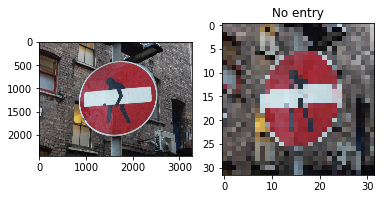

In [56]:
url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/No_entry_sign_on_Grape_Street%2C_London.jpg"
img, og_img = get_image(url)
outputs = predictor.predict(img.tolist())

predicted_label = label_map[np.argmax(np.array(outputs[0]))]
un_normalized_img = np.transpose(img[0], axes=(1,2,0))

plt.figure()
plt.subplot(121)
plt.imshow(og_img)
plt.subplot(122)
plt.title(predicted_label)
plt.imshow(un_normalized_img)

Great! We've now successfully trained our model on SageMaker, and deployed it to an endpoint to do inference in the cloud.

**Note:** Do not forget to **delete your endpoint** below to avoid incurring unintentional costs.

In [135]:
net_sagemaker.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-py2-gpu-2018-02-22-20-51-47-608


## Edge Deployment on AWS DeepLens

So far we've seen how to use MXNet interfaces to build our models, and we've seen how SageMaker simplifies the life-cycle of ML development from conception to cloud deployment. 

However, deploying models for inference is oftentimes something we want to do locally, on-device, and at the edge. Edge computation can be a problem due to resource constraints, and for computer vision models a camera is also necessary.

With AWS DeepLens, developers can deploy models to a fully-programmable video camera designed to run inference at the edge. DeepLens is the world's first deep learning enabled video camera, boasting over 100 GFLOPS of compute power and an Intel Gen9 Graphics Engine that accelerates optimized model inference with local GPU computation.

In order to deploy a model to DeepLens, we need to create a **Project**. A Project consists of a model artifact for doing inference, and a **Lambda** function that actually runs the inference. This includes pre- and post-processing of data, and since DeepLens is an AWS device your Lambda function can integrate with any AWS service.

First we need to import our model into the DeepLens dashboard. Select **Models** from the side bar, then **Import model** to import the model saved by the SageMaker training job. On the Import source page, select "Amazon SageMaker trained model" and choose our training job, "deeplens-traffic-sign-train", from the drop down. You can name the model "deeplens-traffic-sign-lenet" and add a description if you'd like.

Next, we need to create the Lambda function that will run inference on the device. Rather than start from scratch, we're going to modify one of the existing Lambda functions for action recognition. If you've registered your DeepLens, you can find this function populated in the **Functions** sidebar from the Lambda dashboard.

You should see many different things, but we only care about <tt>greengrassHelloWorld.py</tt>. This is the script that runs inference; again, there's a lot happening but we mainly care about the function <tt>greengrass_infinite_infer_run()</tt>. 

This function starts by loading the Intel IR model converted from MXNet (more on this later), specifying the model type, the labels, and the context. Then, the infinite inference loop begins:
* <tt>awscam.getLastFrame()</tt> gets the last frame from the camera input
* the data is resized to the input into model
* <tt>model.doInference</tt> does a forward pass through the optimized model on GPU.
* The model returns the classes in decreasing order of probability
* The label for the predicted class is determined and written to the original frame
* The original frame is saved to the video stream

In [158]:
def greengrass_infinite_infer_run():
    try:
        modelPath = "/opt/awscam/artifacts/mxnet_action_recognition_v2.0_FP16_FUSED.xml"
        modelType = "classification"
        outMap = {0: 'applyeyemakeup', 1: 'applylipstick', 2: 'archery', 3: 'basketball', 4: 'benchpress', 5: 'biking', 6: 'billiards', 7: 'blowdryhair', 8: 'blowingcandles', 9: 'bowling', 10: 'brushingteeth', 11: 'cuttinginkitchen', 12: 'drumming', 13: 'haircut', 14: 'hammering', 15: 'handstandwalking', 16: 'headmassage', 17: 'horseriding', 18: 'hulahoop', 19: 'jugglingballs', 20: 'jumprope', 21: 'jumpingjack', 22: 'lunges', 23: 'nunchucks', 24: 'playingcello', 25: 'playingflute', 26: 'playingguitar', 27: 'playingpiano', 28: 'playingsitar', 29: 'playingviolin', 30: 'pushups', 31: 'shavingbeard', 32: 'skiing', 33: 'typing', 34: 'walkingwithdog', 35: 'writingonboard', 36: 'yoyo'}
        # Send a starting message to IoT console
        client.publish(topic=iotTopic, payload="Action recognition starts now")
        results_thread = FIFO_Thread()
        results_thread.start()

        # Load model to GPU (use {"GPU": 0} for CPU)
        mcfg = {"GPU": 1}
        model = awscam.Model(modelPath, mcfg)
        client.publish(topic=iotTopic, payload="Model loaded")

        doInfer = True
        while doInfer:
            # Get a frame from the video stream
            ret, frame = awscam.getLastFrame()

            # Raise an exception if failing to get a frame
            if ret == False:
                raise Exception("Failed to get frame from the stream")

            # Resize frame to fit model input requirement
            frameResize = cv2.resize(frame, (224, 224))

            # Run model inference on the resized frame
            inferOutput = model.doInference(frameResize)

            outputProcessed = model.parseResult(modelType, inferOutput)

            # Get top 5 results with highest probiblities
            topFive = outputProcessed[modelType][0:5]
            msg = "{"
            probNum = 0 
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, outMap[topFive[0]["label"]], (0,22), font, 1, (255, 165, 20), 4)
            for obj in topFive:
                if probNum == 4: 
                    msg += '"{}": {:.2f}'.format(outMap[obj["label"]], obj["prob"])
                else:
                    msg += '"{}": {:.2f},'.format(outMap[obj["label"]], obj["prob"])
                probNum += 1
            msg += "}"
            client.publish(topic=iotTopic, payload=msg)
            global jpeg
            ret,jpeg = cv2.imencode('.jpg', frame)
    except Exception as e:
        msg = "Test failed: " + str(e)
        client.publish(topic=iotTopic, payload=msg)

    # Asynchronously schedule this function to be run again in 15 seconds
    Timer(15, greengrass_infinite_infer_run).start()

We obviously need to modify this for our use-case.

The action-recognition model explicitly refers to the converted Intel model, which we don't have yet. We have to use the model optimizer method <tt>mo.optimize()</tt> to convert the native MXNet model pushed to the device to the IR format used by Intel. The model optimizer does three things:
* Converts the model to run on top of Intel's GPU compute library, clDNN
* Reduces computation time by "fusing" layers together, optimizing inference for the local GPU.
* Quantizes the weights from full to half floating points, reducing memory overhead.

Other modifications we need to make to the action-recognition function:
* Hard-code our labels instead of action recognition
* Convert matrix from BGR to RGB (OpenCV loads images as BGR)
* Change resizing dimensions to 32x32

**Note:** Make sure to add <tt>import mo</tt> to the top of the Lambda function to import the model optimizer library on the device.

Below you can explicitly see the changes that we're going to make:

In [ ]:
def greengrass_infinite_infer_run():
    try:
        ##CHANGE: Optimize model, returning optimized model path
        error, modelPath = mo.optimize('model', input_width=32, input_height=32, platform='mxNet', aux_inputs = {'--img-format':'RGB'})
        modelType = "classification"
        ## CHANGE: Hard-coded the label mappings for our task
        outMap = {0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory', 41: 'End of no passing', 42: 'End of no passing by vehicles over 3.5 metric tons'}
        # Send a starting message to IoT console
        client.publish(topic=iotTopic, payload="Traffic sign recognition starts now")
        results_thread = FIFO_Thread()
        results_thread.start()

        # Load model to GPU (use {"GPU": 0} for CPU)
        mcfg = {"GPU": 1}
        model = awscam.Model(modelPath, mcfg)
        client.publish(topic=iotTopic, payload="Model loaded")

        doInfer = True
        while doInfer:
            # Get a frame from the video stream
            ret, frame = awscam.getLastFrame()

            # Raise an exception if failing to get a frame
            if ret == False:
                raise Exception("Failed to get frame from the stream")

            # Resize frame to fit model input requirement
            #CHANGE: Preprocessing
            frameRGB = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
            frameResize = cv2.resize(frameRGB, (32, 32))

            # Run model inference on the resized frame
            inferOutput = model.doInference(frameResize)

            outputProcessed = model.parseResult(modelType, inferOutput)

            # Get top 5 results with highest probiblities
            topFive = outputProcessed[modelType][0:5]
            msg = "{"
            probNum = 0 
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, outMap[topFive[0]["label"]], (0,22), font, 1, (255, 165, 20), 4)
            for obj in topFive:
                if probNum == 4: 
                    msg += '"{}": {:.2f}'.format(outMap[obj["label"]], obj["prob"])
                else:
                    msg += '"{}": {:.2f},'.format(outMap[obj["label"]], obj["prob"])
                probNum += 1
            msg += "}"
            client.publish(topic=iotTopic, payload=msg)
            global jpeg
            ret,jpeg = cv2.imencode('.jpg', frame)
    except Exception as e:
        msg = "Test failed: " + str(e)
        client.publish(topic=iotTopic, payload=msg)

    # Asynchronously schedule this function to be run again in 15 seconds
    Timer(15, greengrass_infinite_infer_run).start()


And those are the only changes we need to make to adapt the action recognition Lambda to any other simple classification task. Very easy!

However, we don't want to overwrite the action recognition function so we're going to duplicate the Lambda function. To do this, do the following:
* Select **Export function** from the **Actions** drop down menu at the top of the page.
* Select **Download deployment package**. This will download a zip file.
* Return to the **Functions** page and select **Create function**
* Select **Blueprints**, search and select "greengrass-hello-world", and **Configure**
* Name your function "deeplens-traffic-sign-lenet". Under **Role**, select "Choose an existing role" and select "AWSDeepLensLambdaRole" in the following drop-down. **Create function**
* In the **Function code** pane, under the "Code entry type" drop down, select "Upload a .ZIP file", click **Upload**, select the package zip file you downloaded earlier.

At this point you should have successfully ported the code to a new Lambda function. Now, replace <tt>greengrass_infinite_infer_run</tt> with the one we modified for our model in the previous cell. Finally, click **Save** to save changes and under **Actions** select "Publish new version"

With our Model and Lambda function prepared, we can finally create a Project and deploy to the device. Return to the DeepLens console and **Create new project**:
* Select Create a new blank project
* Name it "deeplens-traffic-sign-classification"
* With **Add model**, select "deeplens-traffic-sign-lenet"
* With **Add function**, select "deeplens-traffic-sign-lenet"
* **Create** and name "Traffic-Sign_Classification"

Once you have the model created, we can finally deploy the project. From the Project page, select **Deploy to device** and choose your DeepLens to deploy to.

At this point, AWS Greengrass pushes the model and Lambda down to your device and starts running the Lambda locally. After you receive confirmation in the Dashboard that the model has been deployed, connect your DeepLen to a monitor and run the following command in the terminal: 
<tt>mplayer -demuxer lavf -lavfdopts format=mjpeg:probesize=32 /tmp/results.mjpeg</tt>

You should be seeing the output of your model now as a video stream with the prediction labels in the top left. 

Below, I've taken a screenshot of DeepLens making a prediction on this image. The image is of a sign on my laptop screen on my desk with some objects under the lighting of a lamp. Even with these environmental factors, the model still makes an accurate prediction of "Turn Left Ahead"!

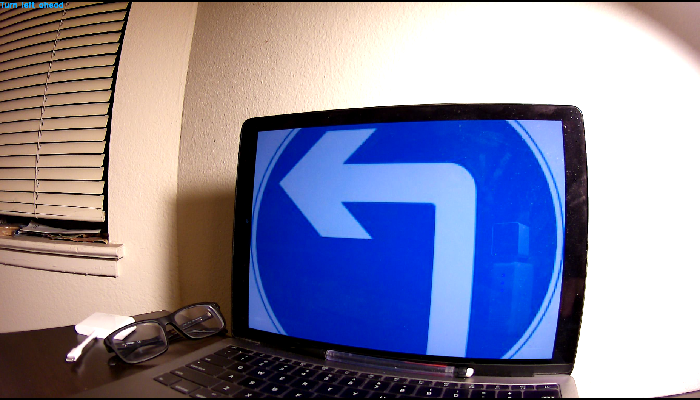

In [77]:
Image.open('traffic.png')

Of course, what the model actually sees is a downsampled 32x32 version of this:

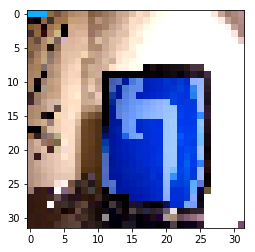

In [76]:
plt.imshow(np.array(Image.open('traffic.png').resize((32,32))))

It's no surprise the model could ignore the other elements since the downsampling effectively removes them.

## Final Thoughts

We've covered a lot of ground in this tutorial to get our model to DeepLens. We took a look at how to prepare image data for training, including preprocessing. We trained models in both MXNet Symbolic and Gluon, comparing and contrasting two distinct approaches to building and training neural networks. We also learned how to convert our training code into a script that SageMaker can use to effortlessly launch training jobs at scale, as well as prop up inference servers ot endpoints. Finally, we learned how to create a DeepLens Project by using our model from SageMaker with a slightly modified action recognition Lambda function. We deployed the model to the device through Greengrass and ran inference locally.

While this use-case is interesting, it is incredibly simple. A 32x32 image barely captures much information, and the task itself was to only classify signs. We chose this task because it's simplicity means it's easy to train a simple model quickly. But what about more complicated classifications on larger images?

We will soon demonstrate how to take models trained on millions of images and adapt them to a similar task through a process known as **Transfer Learning**.